## Cost optimization contd.

### 1. adjust the service level agreement and/or average speed of answer,
The service level (SL), defined as the fraction of calls answered within a given time limit, is a common metric for assessing the quality of service (QoS). Choosing a staffing strategy entails determining how many agents of each skill set should be present in the center. Each agent’s fee is determined by their skill set. The staffing issue is determining a staffing solution that minimizes total cost while meeting QoS requirements. <br>

Average speed of time indicates how quickly a call center is willing to attend to incoming calls. It is the amount of time a call spent in a queue before being connected with an agent.

In [1]:
import gurobipy as gp
from gurobipy import GRB

from pyworkforce.queuing import ErlangC
from pyworkforce.queuing import MultiErlangC

import numpy as np
import pandas as pd
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re
import itertools
from itertools import repeat
import seaborn as sns

In [2]:
%store -r volume
%store -r timeInterval
%store -r staffing_level

Here, just like in the previous section, we are going to solve the model again using different service level of ’60% in 40secs’. With this, we hope to reduce the excess scheduling of agents and achieve variability in achieved service level at different periods.

In [3]:
param_grid = {"transactions": [s for s in volume], "aht": [3], "interval": [15], "asa": [40 / 60]}
multi_erlang = MultiErlangC(param_grid=param_grid, n_jobs=-1)

required_positions_scenarios = {"service_level": [0.6]}

p = multi_erlang.required_positions(required_positions_scenarios)
#print("positions_requirements: ", p)

df = pd.DataFrame.from_dict(p)
df.head()

,raw_positions,positions,service_level,occupancy,waiting_probability
0,43,43,0.722277,0.930233,0.540930
1,46,46,0.689901,0.939130,0.577733
2,34,34,0.745158,0.911765,0.496365
3,9,9,0.661728,0.822222,0.482705
4,66,66,0.684471,0.954545,0.614567


In [4]:
staffing_level_2 = [x["positions"] for x in p]
service_level_2 = [x["service_level"] for x in p]

slots = [str("slot{0}".format(i)) for i in range(1,50)]
t = dict(zip(slots, staffing_level_2))

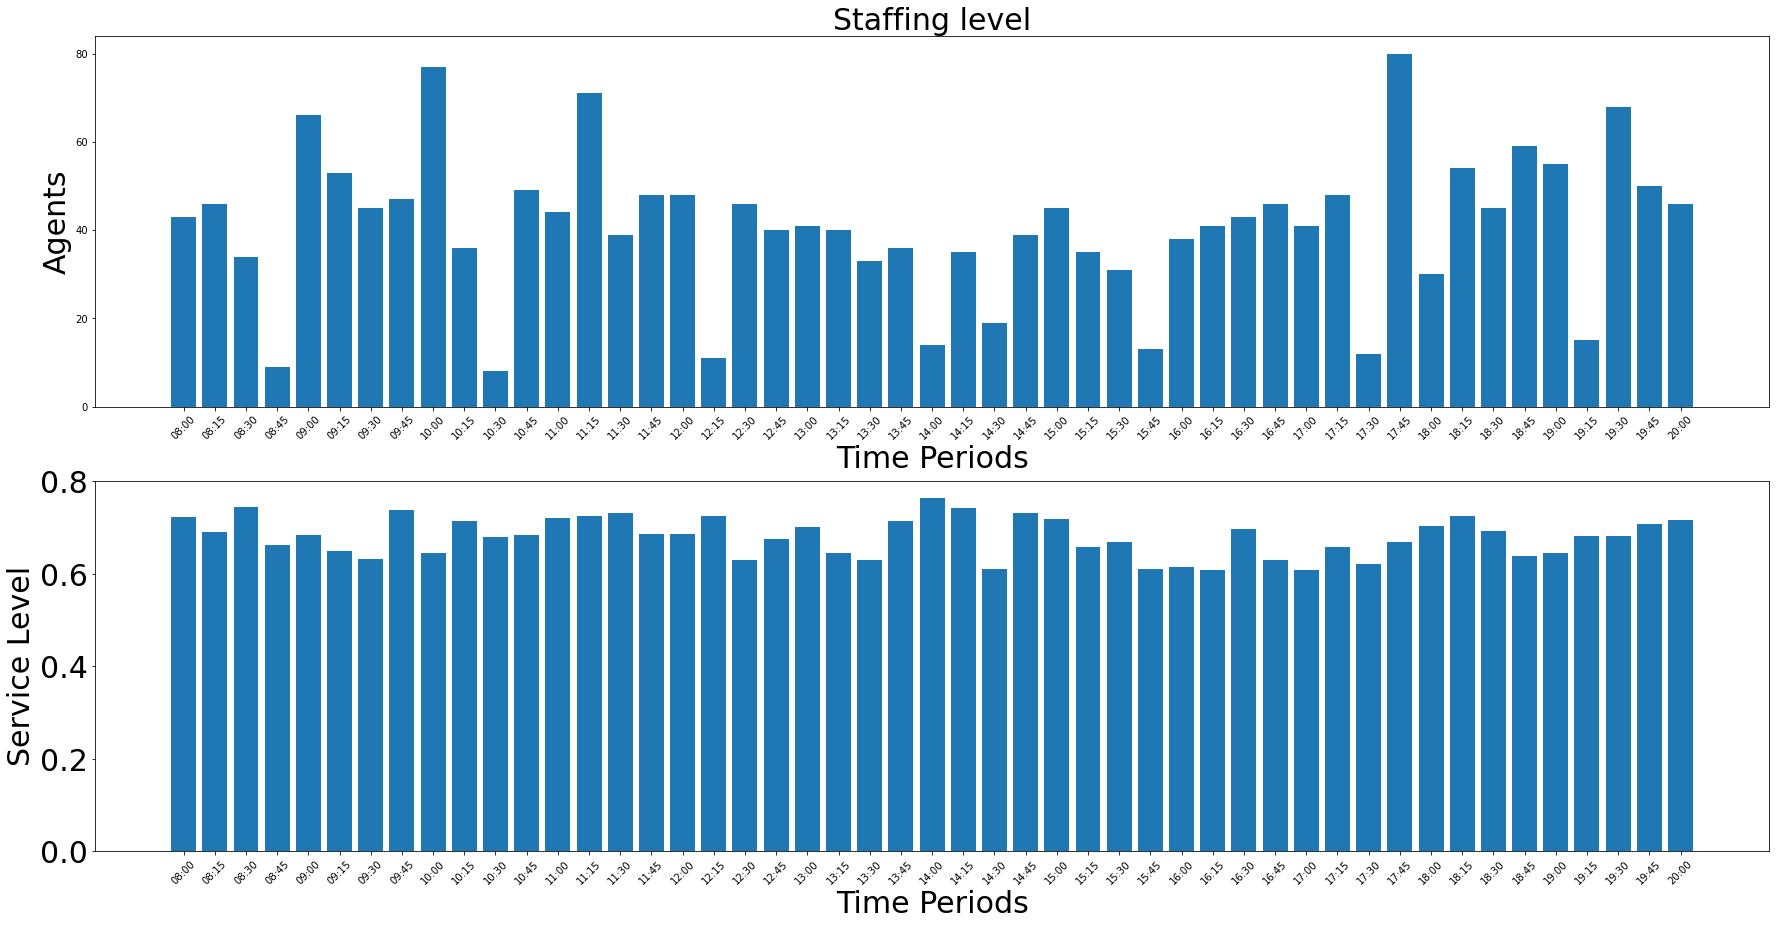

In [5]:
fig = plt.figure()
fig.set_size_inches(30,15)

plt.subplot(2, 1, 1) 
plt.bar(timeInterval, staffing_level_2,linewidth = 4);
plt.xlabel('Time Periods', fontsize=30)
plt.ylabel('Agents', fontsize=30)
plt.rc('ytick', labelsize=30)
plt.title('Staffing level', fontsize=30)
plt.xticks(rotation=45);


plt.subplot(2, 1, 2) 
plt.bar(timeInterval, service_level_2)
plt.xlabel('Time Periods', fontsize=30)
plt.ylabel('Service Level', fontsize=30)
plt.rc('ytick', labelsize=30)
plt.xticks(rotation=45);

In [6]:
timeSlots, staffing_levels = gp.multidict(t)
available_shifts, cost = gp.multidict({"shift1": 72, "shift2": 96, "shift3": 112})
available_shifts, duration = gp.multidict({"shift1": 4, "shift2": 6, "shift3": 8})

In [7]:
matr = []
for i in slots:
    for j in available_shifts:
        matr.append((i, j))

slot_shifts = gp.tuplelist(matr)

In [8]:
m = gp.Model("call_center_WFM_2")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-03


In [9]:
#binary constraint
a_tj = m.addVars(slot_shifts, vtype=GRB.BINARY, name="a_tj")

#available shifts 
actualAgent = m.addVars(available_shifts, vtype=GRB.INTEGER, name='X')

#constraints 1: staffing constraint
shift_reqmts = m.addConstrs((gp.quicksum(a_tj[t,j]*actualAgent[j] for j in available_shifts)
                             >= staffing_levels[t] for t in timeSlots), name = 'staffing_levels')

#constraint 2: Time constraint
Shift_bounds = m.addConstrs((gp.quicksum(a_tj[t,j] for t in timeSlots) 
                                         <= 4*duration[j] for j in available_shifts), 
                                            name = 'Time_bound')

In [10]:
#objective function: to minimize agents' salary
obj = gp.quicksum(actualAgent[j]*cost[j] for j in available_shifts)
m.setObjective(obj , GRB.MINIMIZE)

#set running time to 300secs
m.setParam(GRB.Param.TimeLimit, 300)

#output the problem in gurobi .lp format
m.write('call_center_2.lp')

#optimize the model
m.optimize()

Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3 rows, 150 columns and 147 nonzeros
Model fingerprint: 0x0b86c1de
Model has 49 quadratic constraints
Variable types: 0 continuous, 150 integer (147 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [7e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [8e+00, 8e+01]
Presolve time: 0.00s
Presolved: 346 rows, 591 columns, 1029 nonzeros
Presolved model has 294 SOS constraint(s)
Variable types: 0 continuous, 591 integer (294 binary)

Root relaxation: objective 5.760000e+03, 317 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 

Shifts Requirement
    Shift  Number of agents
0  shift1              24.0
1  shift2              14.0
2  shift3              48.0


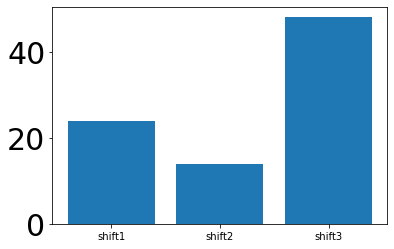

--------------------------------------------------
Shifts distribution
Symbols: '-': not covering, '*': covering
   Time slots shift1 shift2 shift3
0       slot1      -      -      *
1       slot2      -      -      *
2       slot3      *      *      -
3       slot4      -      *      -
4       slot5      *      -      *
5       slot6      -      *      *
6       slot7      -      -      *
7       slot8      -      -      *
8       slot9      *      *      *
9      slot10      *      *      -
10     slot11      -      *      -
11     slot12      -      *      *
12     slot13      -      -      *
13     slot14      *      -      *
14     slot15      -      -      *
15     slot16      -      -      *
16     slot17      -      -      *
17     slot18      -      *      -
18     slot19      -      -      *
19     slot20      -      -      *
20     slot21      -      -      *
21     slot22      -      -      *
22     slot23      *      *      -
23     slot24      *      *      -
24     slot2

In [11]:
solution = {}
shifts_sol = {}
assignments_all = {}
gant={}

assignments = dict()
for [w, s] in list(slot_shifts):
    if a_tj[w, s].x == 1:
        if w in assignments:
            assignments[w].append(s)
        else:
            assignments[w] = [s]

for s in available_shifts:
    shifts_sol[s]=actualAgent[s].X
    
for t in slots:
    assignments_all[t]=assignments.get(t, [])

print('Shifts Requirement')
print(pd.DataFrame.from_records(list(shifts_sol.items()), columns=['Shift', 'Number of agents']))


shiftVar = [str("X[shift{0}]".format(i)) for i in range(1,4)]
varInfo = [(v.varName, v.X) for v in m.getVars() if v.X > 0 and v.varname in shiftVar]
val = [a[1] for a in varInfo]

plt.bar(available_shifts[0:], val)
plt.show()


###########################################
print('-'*50)
for w in assignments_all:
    gant[w] = [w]
    for d in available_shifts:
        gant[w].append('*' if d in assignments_all[w] else '-')
        
print('Shifts distribution')
print('Symbols: \'-\': not covering, \'*\': covering')
print(pd.DataFrame.from_records(list(gant.values()), columns=['Time slots']+available_shifts))

#########################
print('-'*50)
print('optimal cost')
print(m.ObjVal)

In [12]:
a_ij = [str("a_tj[slot{0},shift{1}]".format(i,j)) for i in range(1,50) for j in range(1,4)]

aij_Info = [(v.varName, v.X) for v in m.getVars() if v.X > 0 and v.varname in a_ij]

x = [a[0] for a in aij_Info]

Total_staff_2 = list(itertools.repeat(0,49))
staff_sum = 0
for p in range(1,50):
    for q in range(1,4):
        if str("a_tj[slot{0},shift{1}]".format(p,q)) in x:
           Total_staff_2[p-1] += int(val[q-1])   

In [13]:
%store Total_staff_2

Stored 'Total_staff_2' (list)


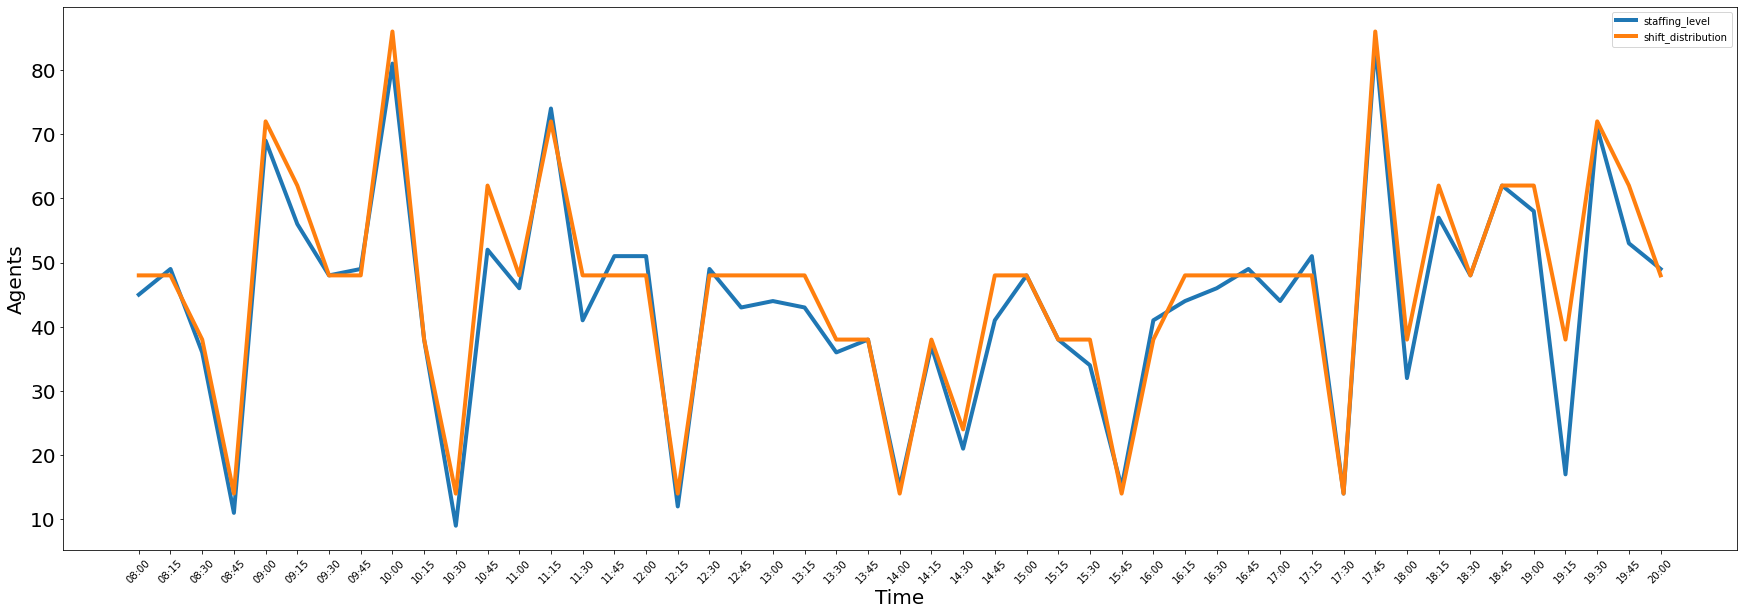

In [16]:
fig = plt.figure()
fig.set_size_inches(30,10)

plt.plot(timeInterval, staffing_level,linewidth = 4, label='staffing_level');
plt.plot(timeInterval, Total_staff_2,linewidth = 4, label='shift_distribution');

plt.xlabel('Time', fontsize=20)
plt.ylabel('Agents', fontsize=20)
plt.rc('ytick', labelsize=20)
plt.xticks(rotation=45);
plt.legend();

We could see the number of agents assigned to each shift and the corresponding total cost. The table above shows that the total number of agents schedulued is 86 as oppose to 92 scheduled by direct application of the model. Also, this schedule shows a reduction of about €576 in the overall personel cost. This seems to be a great improvement. Comparing agent distribution of this method with the initial staffing levels, it is worth noticing that the number of excess schedule has drastically reduced.

Mean of achieved service level
0.8685660405837234


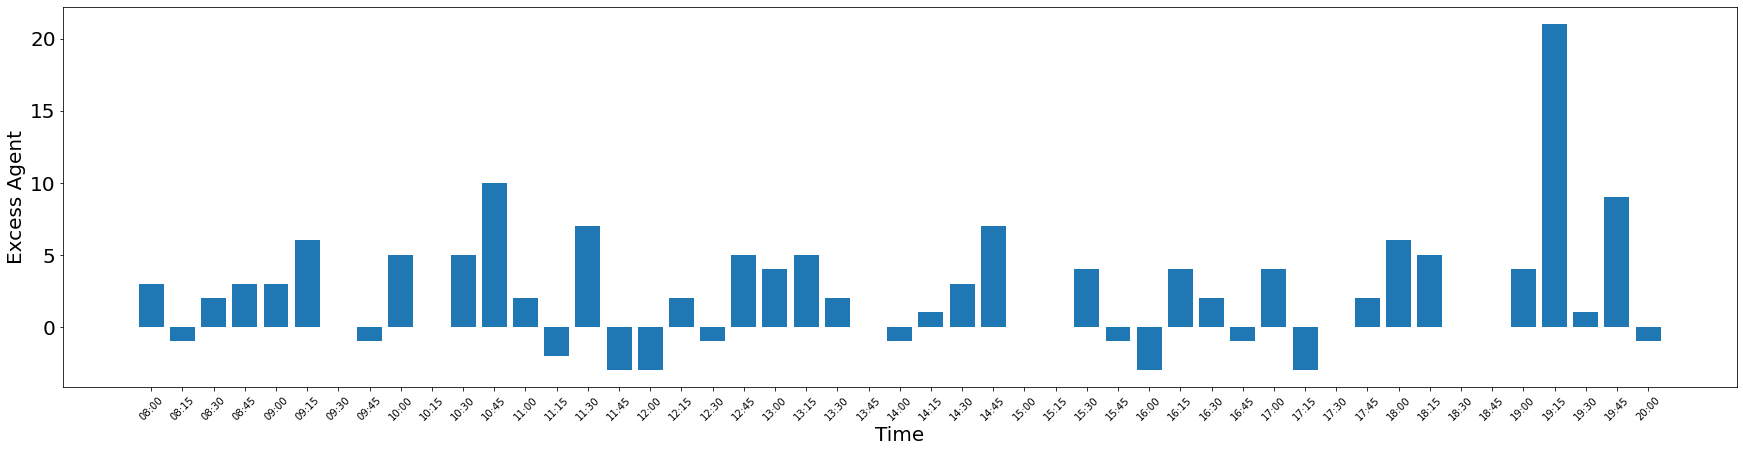

In [15]:
diff = np.array(Total_staff_2) - np.array(staffing_level)

new_SL_2 =[]
for i in range(1,50):
    erlang = ErlangC(transactions=volume[i], aht=3, interval=15, asa=20/60)
    achieved_service_level = erlang.service_level(positions=Total_staff_2[i-1])
    new_SL_2.append(achieved_service_level)

print('Mean of achieved service level')
print(mean(new_SL_2))


fig = plt.figure()
fig.set_size_inches(30,7)

plt.bar(timeInterval, diff.tolist())
plt.xlabel('Time', fontsize=20)
plt.ylabel('Excess Agent', fontsize=20)
plt.xticks(rotation=45);

Lastly, the service level achieved by this method has a mean of 87%.